In [1]:
import requests
import json
import pandas as pd
import random

def get_posts(subreddit, before, after, size):
    url = f"https://api.pushshift.io/reddit/search/submission/?subreddit={subreddit}&size={size}&before={before}&after={after}"
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

# Scrape 2000 legal question titles
legal_questions = []
size = 100
after = "7d" # posts from the last 7 days
before = "" # no upper time limit
subreddit = "legaladvice"
while len(legal_questions) < 2000: # scrape until we have 2000 legal questions
    data = get_posts(subreddit, before, after, size)
    if not data: # if data is empty, break out of loop
        break
    for post in data:
        if post["title"][-1] == "?" and len(legal_questions) < 2000:
            legal_questions.append({"title": post["title"], "label": 1})
        if len(legal_questions) >= 2000: # break out of loop if we have 2000 legal questions
            break
    before = data[-1]["created_utc"] # set before time for next page

# Scrape 2000 non-legal question titles
non_legal_questions = []
size = 100
after = "7d" # posts from the last 7 days
before = "" # no upper time limit
subreddit = "askreddit"
keywords = ["legal", "law", "court"]
while len(non_legal_questions) < 2000: # scrape until we have 2000 non-legal questions
    data = get_posts(subreddit, before, after, size)
    if not data: # if data is empty, break out of loop
        break
    for post in data:
        title = post["title"]
        if not any(keyword in title.lower() for keyword in keywords) and title[-1] == "?" and len(non_legal_questions) < 2000:
            non_legal_questions.append({"title": title, "label": 0})
            if len(non_legal_questions) >= 2000: # break out of loop if we have 2000 non-legal questions
                break
    before = data[-1]["created_utc"] # set before time for next page

# Combine legal and non-legal questions into a single list and shuffle the order
questions = legal_questions + non_legal_questions
random.shuffle(questions)

# Convert list of questions to a dataframe and save to a CSV file
df = pd.DataFrame(questions)
df.to_csv("questions.csv", index=False)


In [2]:
import pandas as pd
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to classify legal questions based on serenity
def classify_serenity(question):
    # tokenize the question
    tokens = word_tokenize(question)
    # remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]
    # check if question contains keywords indicating a high-serenity issue
    if any(keyword in tokens for keyword in ["emergency", "urgent", "serious", "severe", "imminent", "dangerous"]):
        return 4  # high-serenity
    # check if question contains keywords indicating a medium-serenity issue
    elif any(keyword in tokens for keyword in ["important", "concerned", "need", "worried", "issue"]):
        return 3  # medium-serenity
    # check if question contains keywords indicating a low-serenity issue
    elif any(keyword in tokens for keyword in ["minor", "trivial", "small", "insignificant", "nuisance"]):
        return 2  # low-serenity
    # default: 0 serenity
    else:
        return 1

# read questions from CSV file
df = pd.read_csv("questions.csv")

# classify legal questions based on serenity
df.loc[:, 'serenity'] = df['title'].apply(classify_serenity)

# set serenity value to 0 for non-legal questions
df.loc[df['label'] == 0, 'serenity'] = 0

# drop label column
df = df.drop(columns=['label'])

# save classified questions to CSV file
df.to_csv("classified_questions.csv", index=False)

print("Saved", len(df), "classified questions to classified_questions.csv.")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saved 3171 classified questions to classified_questions.csv.


In [4]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

# load data from legal_questions.csv
df = pd.read_csv("classified_questions.csv")

# prepare data for training
X = df['title'].values
y = df['serenity'].values

# vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

# train a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X, y)

# predict the serenity of a new question
new_question = input("Enter your legal question: ")
new_question_vec = vectorizer.transform([new_question])
predicted_serenity = clf.predict(new_question_vec)[0]
print("Predicted serenity:", predicted_serenity)


Enter your legal question: Can insurance company issue payment to bank if I submitted a counter offer?
Predicted serenity: 3


In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

# load dataset
df = pd.read_csv('classified_questions.csv')

# split into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# vectorize text data
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# train logistic regression model
lr = LogisticRegression()
lr.fit(train_vectors, train_labels)

# make predictions on test set
pred_labels = lr.predict(test_vectors)

# calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.3f}")

# calculate f1 score
f1 = f1_score(test_labels, pred_labels, average='weighted')
print(f"F1 score: {f1:.3f}")

# calculate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
print("Confusion matrix:")
print(cm)


Accuracy: 0.913
F1 score: 0.905
Confusion matrix:
[[391  13   0   0   0]
 [ 30 188   0   0   0]
 [  3   2   0   0   0]
 [  0   5   0   1   0]
 [  0   2   0   0   0]]


Accuracy: 0.913
F1 score: 0.905
Confusion matrix:
[[391  13   0   0   0]
 [ 30 188   0   0   0]
 [  3   2   0   0   0]
 [  0   5   0   1   0]
 [  0   2   0   0   0]]


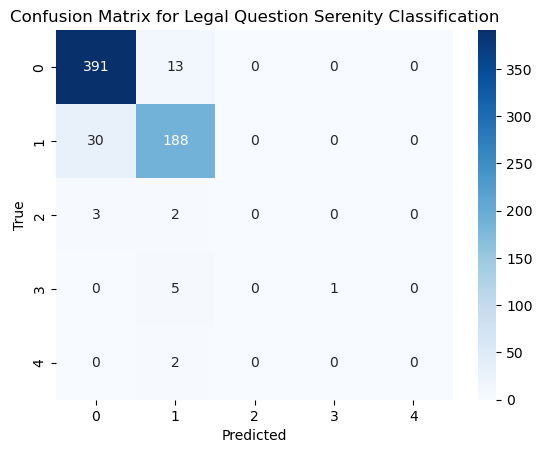

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# load dataset
df = pd.read_csv('classified_questions.csv')

# split into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# vectorize text data
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# train logistic regression model
lr = LogisticRegression()
lr.fit(train_vectors, train_labels)

# make predictions on test set
pred_labels = lr.predict(test_vectors)

# calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.3f}")

# calculate f1 score
f1 = f1_score(test_labels, pred_labels, average='weighted')
print(f"F1 score: {f1:.3f}")

# calculate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
print("Confusion matrix:")
print(cm)

# create heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# set plot labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Legal Question Serenity Classification")

# show plot
plt.show()


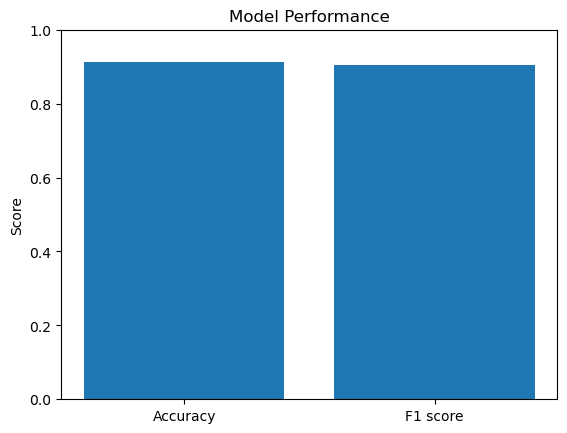

In [3]:
import matplotlib.pyplot as plt

# plot bar chart of accuracy and f1 score
plt.bar(['Accuracy', 'F1 score'], [accuracy, f1])
plt.ylim(0, 1)
plt.title('Model Performance')
plt.ylabel('Score')
plt.show()


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# load dataset
df = pd.read_csv('classified_questions.csv')

# split into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# vectorize text data
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# train logistic regression model
lr = LogisticRegression()
lr.fit(train_vectors, train_labels)

# make predictions on test set
pred_labels = lr.predict(test_vectors)

# calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.3f}")

# calculate precision
precision = precision_score(test_labels, pred_labels, average='macro')
print(f"Precision: {precision:.3f}")

# calculate recall
recall = recall_score(test_labels, pred_labels, average='macro')
print(f"Recall: {recall:.3f}")

# calculate F1 macro
f1_macro = f1_score(test_labels, pred_labels, average='macro')
print(f"F1 Macro: {f1_macro:.3f}")

# calculate F1 micro
f1_micro = f1_score(test_labels, pred_labels, average='micro')
print(f"F1 Micro: {f1_micro:.3f}")

# calculate macro MAE
mae_macro = mean_absolute_error(test_labels, pred_labels, multioutput='uniform_average')
print(f"Macro MAE: {mae_macro:.3f}")

# calculate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
print("Confusion matrix:")
print(cm)


Accuracy: 0.913
Precision: 0.563
Recall: 0.399
F1 Macro: 0.422
F1 Micro: 0.913
Macro MAE: 0.106
Confusion matrix:
[[391  13   0   0   0]
 [ 30 188   0   0   0]
 [  3   2   0   0   0]
 [  0   5   0   1   0]
 [  0   2   0   0   0]]


/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to extract features from question text
def extract_features(question):
    # tokenize the question
    tokens = word_tokenize(question)
    # remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]
    # compute frequency distribution of the tokens
    freq_dist = FreqDist(tokens)
    # return the 20 most frequent tokens as features
    return dict(freq_dist.most_common(20))

# read classified questions from CSV file
df = pd.read_csv("classified_questions.csv")

# extract features from questions
featuresets = [(extract_features(row['title']), row['serenity']) for index, row in df.iterrows()]

# split featuresets into training and testing sets (80/20 split)
split_index = int(len(featuresets) * 0.8)
train_set = featuresets[:split_index]
test_set = featuresets[split_index:]

# train a Naive Bayes classifier on the training set
classifier = NaiveBayesClassifier.train(train_set)

# evaluate the classifier on the testing set
accuracy = nltk.classify.accuracy(classifier, test_set)
print("Classifier accuracy:", accuracy)

# example usage of the classifier
new_question = input("Enter your legal question: ")
features = extract_features(new_question)
predicted_label = classifier.classify(features)
print("Predicted label for question", new_question, ":", predicted_label)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Classifier accuracy: 0.13858267716535433
Enter your legal question: who is Imran khan?
Predicted label for question who is Imran khan? : 0


In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, fbeta_score

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to extract features from question text
def extract_features(question):
    # tokenize the question
    tokens = word_tokenize(question)
    # remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]
    # compute frequency distribution of the tokens
    freq_dist = FreqDist(tokens)
    # return the 20 most frequent tokens as features
    return dict(freq_dist.most_common(20))

# read classified questions from CSV file
df = pd.read_csv("classified_questions.csv")

# extract features from questions
featuresets = [(extract_features(row['title']), row['serenity']) for index, row in df.iterrows()]

# split featuresets into training and testing sets (80/20 split)
split_index = int(len(featuresets) * 0.8)
train_set = featuresets[:split_index]
test_set = featuresets[split_index:]

# train a Naive Bayes classifier on the training set
classifier = NaiveBayesClassifier.train(train_set)

# evaluate the classifier on the testing set
y_true = [label for _, label in test_set]
y_pred = [classifier.classify(features) for features, _ in test_set]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
macro_mae = fbeta_score(y_true, y_pred, beta=1, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 macro:", f1_macro)
print("F1 micro:", f1_micro)
print("Macro MAE:", macro_mae)

# example usage of the classifier
new_question = input("Enter your legal question: ")
features = extract_features(new_question)
predicted_label = classifier.classify(features)
print("Predicted label for question", new_question, ":", predicted_label)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.13858267716535433
Precision: 0.5081861995903064
Recall: 0.42684582743988686
F1 macro: 0.24355163993568554
F1 micro: 0.13858267716535433
Macro MAE: 0.24355163993568554
Enter your legal question: what should I do when someone kill my manager?
Predicted label for question what should I do when someone kill my manager? : 4


In [3]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to preprocess text
def preprocess_text(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    # remove stopwords and punctuation, lowercase text
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.isalpha()]
    # join tokens back into text
    return ' '.join(tokens)

# read classified questions from CSV file
df = pd.read_csv("classified_questions.csv")

# preprocess question text
df.loc[:, 'title'] = df['title'].apply(preprocess_text)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# create bag-of-words representation of training data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)

# train support vector machine model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_bow, y_train)

# create bag-of-words representation of testing data
X_test_bow = vectorizer.transform(X_test)

# predict serenity of testing data using SVM model
y_pred = svm_model.predict(X_test_bow)

# calculate accuracy of SVM model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.8755905511811024


In [3]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to preprocess text
def preprocess_text(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    # remove stopwords and punctuation, lowercase text
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.isalpha()]
    # join tokens back into text
    return ' '.join(tokens)

# read classified questions from CSV file
df = pd.read_csv("classified_questions.csv")

# preprocess question text
df.loc[:, 'title'] = df['title'].apply(preprocess_text)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# create bag-of-words representation of training data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)

# train support vector machine model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_bow, y_train)

# create bag-of-words representation of testing data
X_test_bow = vectorizer.transform(X_test)

# predict serenity of testing data using SVM model
y_pred = svm_model.predict(X_test_bow)

# calculate evaluation metrics of SVM model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='serene', average='weighted')
recall = recall_score(y_test, y_pred, pos_label='serene', average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
macro_mae = 1 - f1_score(y_test, y_pred, average='macro')

# print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Macro:", f1_macro)
print("F1 Micro:", f1_micro)
print("Macro MAE:", macro_mae)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.8755905511811024
Precision: 0.8737545684147973
Recall: 0.8755905511811024
F1 Macro: 0.6114784655974588
F1 Micro: 0.8755905511811024
Macro MAE: 0.3885215344025412


/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [8]:
import pandas as pd

# read the two CSV files into data frames
df1 = pd.read_csv('questions.csv')
df2 = pd.read_csv('questions2.csv')

# concatenate the two data frames vertically
merged_df = pd.concat([df1, df2], ignore_index=True)

# shuffle the merged data frame
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

# save the shuffled data frame to a new CSV file
shuffled_df.to_csv('newquestions.csv', index=False)


Accuracy: 0.872
F1 score: 0.858
Confusion matrix:
[[404   0   0   0   0]
 [ 68 150   0   0   0]
 [  4   1   0   0   0]
 [  1   5   0   0   0]
 [  2   0   0   0   0]]


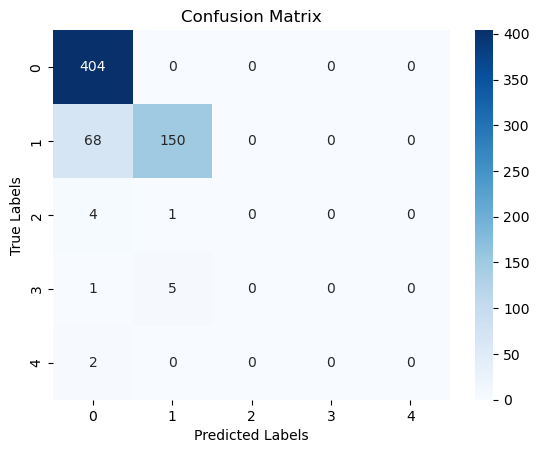

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# load dataset
df = pd.read_csv('classified_questions.csv')

# split into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# vectorize text data
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# train Naïve Bayes model
nb = MultinomialNB()
nb.fit(train_vectors, train_labels)

# make predictions on test set
pred_labels = nb.predict(test_vectors)

# calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.3f}")

# calculate f1 score
f1 = f1_score(test_labels, pred_labels, average='weighted')
print(f"F1 score: {f1:.3f}")

# calculate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
print("Confusion matrix:")
print(cm)

# visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [9]:
import pandas as pd
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to classify legal questions based on serenity
def classify_serenity(question):
    # tokenize the question
    tokens = word_tokenize(question)
    # remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]
    # check if question contains keywords indicating a high-serenity issue
    if any(keyword in tokens for keyword in ["emergency", "urgent", "serious", "severe", "imminent", "dangerous"]):
        return 4  # high-serenity
    # check if question contains keywords indicating a medium-serenity issue
    elif any(keyword in tokens for keyword in ["important", "concerned", "need", "worried", "issue"]):
        return 3  # medium-serenity
    # check if question contains keywords indicating a low-serenity issue
    elif any(keyword in tokens for keyword in ["minor", "trivial", "small", "insignificant", "nuisance"]):
        return 2  # low-serenity
    # default: 0 serenity
    else:
        return 1

# read questions from CSV file
df = pd.read_csv("newquestions.csv")

# classify legal questions based on serenity
df.loc[:, 'serenity'] = df['title'].apply(classify_serenity)

# set serenity value to 0 for non-legal questions
df.loc[df['label'] == 0, 'serenity'] = 0

# drop label column
df = df.drop(columns=['label'])

# save classified questions to CSV file
df.to_csv("classified_questions2.csv", index=False)

print("Saved", len(df), "classified questions to classified_questions.csv.")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saved 4047 classified questions to classified_questions.csv.


In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

# load data from legal_questions.csv
df = pd.read_csv("classified_questions2.csv")

# prepare data for training
X = df['title'].values
y = df['serenity'].values

# vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

# train a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X, y)

# predict the serenity of a new question
new_question = input("Enter your legal question: ")
new_question_vec = vectorizer.transform([new_question])
predicted_serenity = clf.predict(new_question_vec)[0]
print("Predicted serenity:", predicted_serenity)


Enter your legal question: Can insurance company issue payment to bank if I submitted a counter offer?
Predicted serenity: 3


In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

# load dataset
df = pd.read_csv('classified_questions2.csv')

# split into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# vectorize text data
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# train logistic regression model
lr = LogisticRegression()
lr.fit(train_vectors, train_labels)

# make predictions on test set
pred_labels = lr.predict(test_vectors)

# calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.3f}")

# calculate f1 score
f1 = f1_score(test_labels, pred_labels, average='weighted')
print(f"F1 score: {f1:.3f}")

# calculate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
print("Confusion matrix:")
print(cm)


Accuracy: 0.926
F1 score: 0.924
Confusion matrix:
[[357  13   0   0   0]
 [ 36 206   0   1   1]
 [  0   3   0   0   0]
 [  2   3   0  74   0]
 [  0   1   0   0 113]]


Accuracy: 0.926
F1 score: 0.924
Confusion matrix:
[[357  13   0   0   0]
 [ 36 206   0   1   1]
 [  0   3   0   0   0]
 [  2   3   0  74   0]
 [  0   1   0   0 113]]


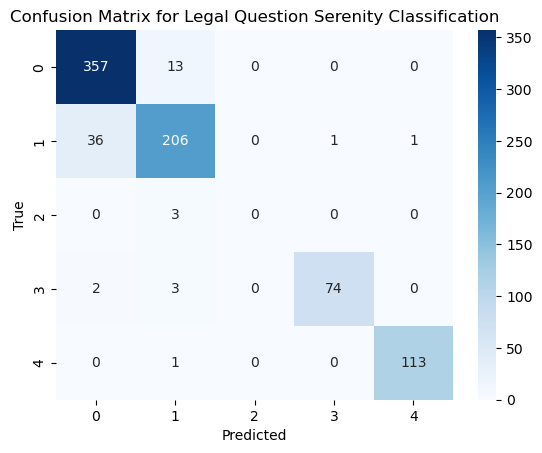

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# load dataset
df = pd.read_csv('classified_questions2.csv')

# split into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# vectorize text data
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# train logistic regression model
lr = LogisticRegression()
lr.fit(train_vectors, train_labels)

# make predictions on test set
pred_labels = lr.predict(test_vectors)

# calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.3f}")

# calculate f1 score
f1 = f1_score(test_labels, pred_labels, average='weighted')
print(f"F1 score: {f1:.3f}")

# calculate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
print("Confusion matrix:")
print(cm)

# create heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# set plot labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Legal Question Serenity Classification")

# show plot
plt.show()


Accuracy: 0.913
F1 score: 0.905
Confusion matrix:
[[391  13   0   0   0]
 [ 30 188   0   0   0]
 [  3   2   0   0   0]
 [  0   5   0   1   0]
 [  0   2   0   0   0]]


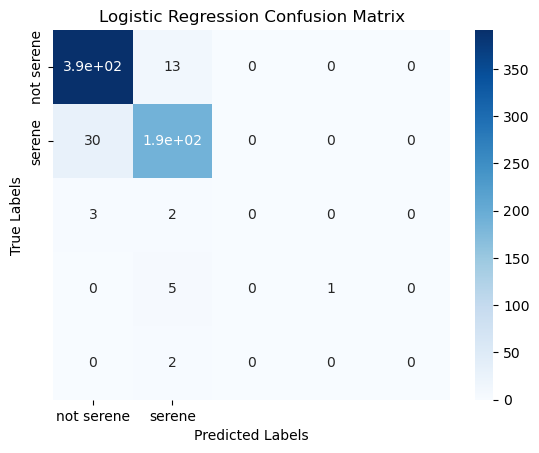

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# load dataset
df = pd.read_csv('classified_questions.csv')

# split into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# vectorize text data
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# train logistic regression model
lr = LogisticRegression()
lr.fit(train_vectors, train_labels)

# make predictions on test set
pred_labels = lr.predict(test_vectors)

# calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.3f}")

# calculate f1 score
f1 = f1_score(test_labels, pred_labels, average='weighted')
print(f"F1 score: {f1:.3f}")

# calculate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
print("Confusion matrix:")
print(cm)

# plot confusion matrix
labels = ['not serene', 'serene']
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Confusion Matrix:
[[376  24   0   4   0]
 [ 45 173   0   0   0]
 [  2   0   3   0   0]
 [  1   1   0   4   0]
 [  0   2   0   0   0]]


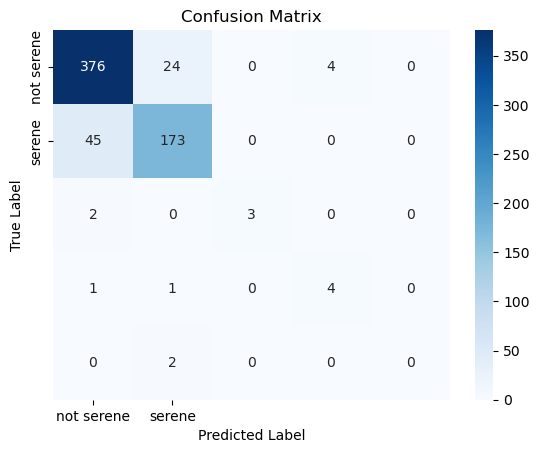

F1 Score: 0.8733011127405621
Accuracy: 0.8755905511811024


In [14]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to preprocess text
def preprocess_text(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    # remove stopwords and punctuation, lowercase text
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.isalpha()]
    # join tokens back into text
    return ' '.join(tokens)

# read classified questions from CSV file
df = pd.read_csv("classified_questions.csv")

# preprocess question text
df.loc[:, 'title'] = df['title'].apply(preprocess_text)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# create bag-of-words representation of training data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)

# train support vector machine model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_bow, y_train)

# create bag-of-words representation of testing data
X_test_bow = vectorizer.transform(X_test)

# predict serenity of testing data using SVM model
y_pred = svm_model.predict(X_test_bow)

# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# create heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["not serene", "serene"], yticklabels=["not serene", "serene"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate f1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)


# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)




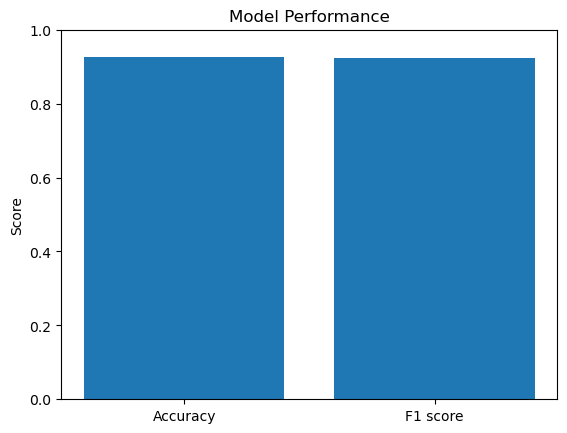

In [13]:
import matplotlib.pyplot as plt

# plot bar chart of accuracy and f1 score
plt.bar(['Accuracy', 'F1 score'], [accuracy, f1])
plt.ylim(0, 1)
plt.title('Model Performance')
plt.ylabel('Score')
plt.show()


In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# load dataset
df = pd.read_csv('classified_questions2.csv')

# split into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# vectorize text data
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# train logistic regression model
lr = LogisticRegression()
lr.fit(train_vectors, train_labels)

# make predictions on test set
pred_labels = lr.predict(test_vectors)

# calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.3f}")

# calculate precision
precision = precision_score(test_labels, pred_labels, average='macro')
print(f"Precision: {precision:.3f}")

# calculate recall
recall = recall_score(test_labels, pred_labels, average='macro')
print(f"Recall: {recall:.3f}")

# calculate F1 macro
f1_macro = f1_score(test_labels, pred_labels, average='macro')
print(f"F1 Macro: {f1_macro:.3f}")

# calculate F1 micro
f1_micro = f1_score(test_labels, pred_labels, average='micro')
print(f"F1 Micro: {f1_micro:.3f}")

# calculate macro MAE
mae_macro = mean_absolute_error(test_labels, pred_labels, multioutput='uniform_average')
print(f"Macro MAE: {mae_macro:.3f}")

# calculate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
print("Confusion matrix:")
print(cm) logistic regression


Accuracy: 0.926
Precision: 0.759
Recall: 0.747
F1 Macro: 0.752
F1 Micro: 0.926
Macro MAE: 0.089
Confusion matrix:
[[357  13   0   0   0]
 [ 36 206   0   1   1]
 [  0   3   0   0   0]
 [  2   3   0  74   0]
 [  0   1   0   0 113]]


/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.926
Precision: 0.759
Recall: 0.747
F1 Macro: 0.752
F1 Micro: 0.926
Macro MAE: 0.089
Confusion matrix:
[[357  13   0   0   0]
 [ 36 206   0   1   1]
 [  0   3   0   0   0]
 [  2   3   0  74   0]
 [  0   1   0   0 113]]
Confusion matrix accuracy: 0.926
Confusion matrix F1 score: 0.752


/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


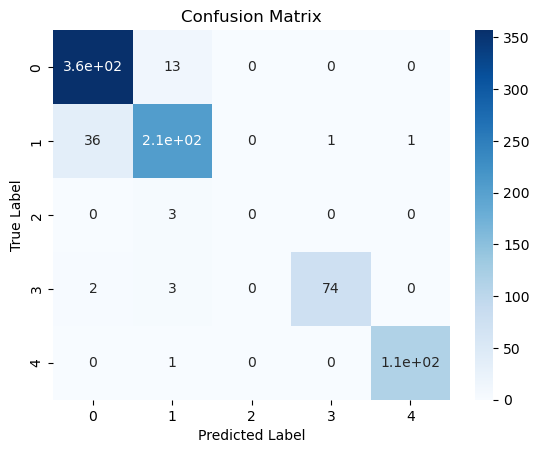

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# load dataset
df = pd.read_csv('classified_questions2.csv')

# split into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# vectorize text data
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# train logistic regression model
lr = LogisticRegression()
lr.fit(train_vectors, train_labels)

# make predictions on test set
pred_labels = lr.predict(test_vectors)

# calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.3f}")

# calculate precision
precision = precision_score(test_labels, pred_labels, average='macro')
print(f"Precision: {precision:.3f}")

# calculate recall
recall = recall_score(test_labels, pred_labels, average='macro')
print(f"Recall: {recall:.3f}")

# calculate F1 macro
f1_macro = f1_score(test_labels, pred_labels, average='macro')
print(f"F1 Macro: {f1_macro:.3f}")

# calculate F1 micro
f1_micro = f1_score(test_labels, pred_labels, average='micro')
print(f"F1 Micro: {f1_micro:.3f}")

# calculate macro MAE
mae_macro = mean_absolute_error(test_labels, pred_labels, multioutput='uniform_average')
print(f"Macro MAE: {mae_macro:.3f}")

# calculate confusion matrix
cm = confusion_matrix(test_labels, pred_labels, labels=lr.classes_)
print("Confusion matrix:")
print(cm)

# calculate confusion matrix accuracy
cm_accuracy = accuracy_score(test_labels, pred_labels)
print(f"Confusion matrix accuracy: {cm_accuracy:.3f}")

# calculate confusion matrix F1 score
cm_f1 = f1_score(test_labels, pred_labels, average='macro')
print(f"Confusion matrix F1 score: {cm_f1:.3f}")

# plot confusion matrix
cm_df = pd.DataFrame(cm, index=lr.classes_, columns=lr.classes_)
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [15]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to extract features from question text
def extract_features(question):
    # tokenize the question
    tokens = word_tokenize(question)
    # remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]
    # compute frequency distribution of the tokens
    freq_dist = FreqDist(tokens)
    # return the 20 most frequent tokens as features
    return dict(freq_dist.most_common(20))

# read classified questions from CSV file
df = pd.read_csv("classified_questions2.csv")

# extract features from questions
featuresets = [(extract_features(row['title']), row['serenity']) for index, row in df.iterrows()]

# split featuresets into training and testing sets (80/20 split)
split_index = int(len(featuresets) * 0.8)
train_set = featuresets[:split_index]
test_set = featuresets[split_index:]

# train a Naive Bayes classifier on the training set
classifier = NaiveBayesClassifier.train(train_set)

# evaluate the classifier on the testing set
accuracy = nltk.classify.accuracy(classifier, test_set)
print("Classifier accuracy:", accuracy)

# example usage of the classifier
new_question = input("Enter your legal question: ")
features = extract_features(new_question)
predicted_label = classifier.classify(features)
print("Predicted label for question", new_question, ":", predicted_label)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Classifier accuracy: 0.4049382716049383
Enter your legal question: who is Imran khan?
Predicted label for question who is Imran khan? : 0


In [16]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, fbeta_score

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to extract features from question text
def extract_features(question):
    # tokenize the question
    tokens = word_tokenize(question)
    # remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]
    # compute frequency distribution of the tokens
    freq_dist = FreqDist(tokens)
    # return the 20 most frequent tokens as features
    return dict(freq_dist.most_common(20))

# read classified questions from CSV file
df = pd.read_csv("classified_questions2.csv")

# extract features from questions
featuresets = [(extract_features(row['title']), row['serenity']) for index, row in df.iterrows()]

# split featuresets into training and testing sets (80/20 split)
split_index = int(len(featuresets) * 0.8)
train_set = featuresets[:split_index]
test_set = featuresets[split_index:]

# train a Naive Bayes classifier on the training set
classifier = NaiveBayesClassifier.train(train_set)

# evaluate the classifier on the testing set
y_true = [label for _, label in test_set]
y_pred = [classifier.classify(features) for features, _ in test_set]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
macro_mae = fbeta_score(y_true, y_pred, beta=1, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 macro:", f1_macro)
print("F1 micro:", f1_micro)
print("Macro MAE:", macro_mae)

# example usage of the classifier
new_question = input("Enter your legal question: ")
features = extract_features(new_question)
predicted_label = classifier.classify(features)
print("Predicted label for question", new_question, ":", predicted_label)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.4049382716049383
Precision: 0.7347764383977794
Recall: 0.6676228560631736
F1 macro: 0.5195482944709635
F1 micro: 0.4049382716049383
Macro MAE: 0.5195482944709635
Enter your legal question: who is Imran Khan?
Predicted label for question who is Imran Khan? : 0


In [17]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to extract features from question text
def extract_features(question):
    # tokenize the question
    tokens = word_tokenize(question)
    # remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]
    # compute frequency distribution of the tokens
    freq_dist = FreqDist(tokens)
    # return the 20 most frequent tokens as features
    return dict(freq_dist.most_common(20))

# read classified questions from CSV file
df = pd.read_csv("classified_questions2.csv")

# extract features from questions
featuresets = [(extract_features(row['title']), row['serenity']) for index, row in df.iterrows()]

# split featuresets into training and testing sets (80/20 split)
split_index = int(len(featuresets) * 0.8)
train_set = featuresets[:split_index]
test_set = featuresets[split_index:]

# train a Naive Bayes classifier on the training set
classifier = NaiveBayesClassifier.train(train_set)

# evaluate the classifier on the testing set
y_true = [label for _, label in test_set]
y_pred = [classifier.classify(features) for features, _ in test_set]
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("F1 macro:", f1_macro)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Confusion matrix:
[[116   5 296   0   0]
 [  9  31 154   6   5]
 [  0   0   5   0   0]
 [  0   0   6  67   0]
 [  0   0   1   0 109]]
Accuracy: 0.4049382716049383
F1 macro: 0.5195482944709635


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


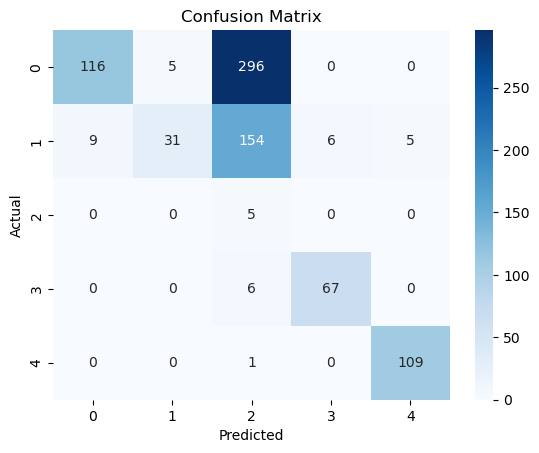

Accuracy: 0.4049382716049383
F1 macro: 0.5195482944709635


In [16]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to extract features from question text
def extract_features(question):
    # tokenize the question
    tokens = word_tokenize(question)
    # remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]
    # compute frequency distribution of the tokens
    freq_dist = FreqDist(tokens)
    # return the 20 most frequent tokens as features
    return dict(freq_dist.most_common(20))

# read classified questions from CSV file
df = pd.read_csv("classified_questions2.csv")

# extract features from questions
featuresets = [(extract_features(row['title']), row['serenity']) for index, row in df.iterrows()]

# split featuresets into training and testing sets (80/20 split)
split_index = int(len(featuresets) * 0.8)
train_set = featuresets[:split_index]
test_set = featuresets[split_index:]

# train a Naive Bayes classifier on the training set
classifier = NaiveBayesClassifier.train(train_set)

# evaluate the classifier on the testing set
y_true = [label for _, label in test_set]
y_pred = [classifier.classify(features) for features, _ in test_set]
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
print("F1 macro:", f1_macro)


In [17]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to preprocess text
def preprocess_text(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    # remove stopwords and punctuation, lowercase text
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.isalpha()]
    # join tokens back into text
    return ' '.join(tokens)

# read classified questions from CSV file
df = pd.read_csv("classified_questions2.csv")

# preprocess question text
df.loc[:, 'title'] = df['title'].apply(preprocess_text)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# create bag-of-words representation of training data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)

# train support vector machine model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_bow, y_train)

# create bag-of-words representation of testing data
X_test_bow = vectorizer.transform(X_test)

# predict serenity of testing data using SVM model
y_pred = svm_model.predict(X_test_bow)

# calculate accuracy of SVM model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.9111111111111111


In [18]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to preprocess text
def preprocess_text(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    # remove stopwords and punctuation, lowercase text
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.isalpha()]
    # join tokens back into text
    return ' '.join(tokens)

# read classified questions from CSV file
df = pd.read_csv("classified_questions2.csv")

# preprocess question text
df.loc[:, 'title'] = df['title'].apply(preprocess_text)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# create bag-of-words representation of training data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)

# train support vector machine model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_bow, y_train)

# create bag-of-words representation of testing data
X_test_bow = vectorizer.transform(X_test)

# predict serenity of testing data using SVM model
y_pred = svm_model.predict(X_test_bow)

# calculate evaluation metrics of SVM model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='serene', average='weighted')
recall = recall_score(y_test, y_pred, pos_label='serene', average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
macro_mae = 1 - f1_score(y_test, y_pred, average='macro')

# print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Macro:", f1_macro)
print("F1 Micro:", f1_micro)
print("Macro MAE:", macro_mae)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.9111111111111111
Precision: 0.9148441155657131
Recall: 0.9111111111111111
F1 Macro: 0.9474462173995549
F1 Micro: 0.9111111111111111
Macro MAE: 0.052553782600445076


/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


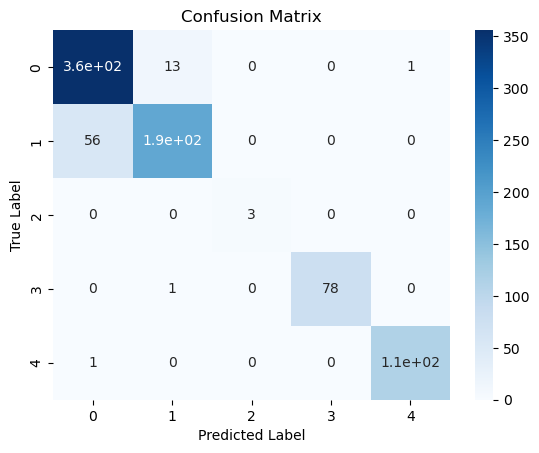

Accuracy: 0.9111111111111111
Precision: 0.9148441155657131
Recall: 0.9111111111111111
F1 Macro: 0.9474462173995549
F1 Micro: 0.9111111111111111
Macro MAE: 0.052553782600445076


In [25]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to preprocess text
def preprocess_text(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    # remove stopwords and punctuation, lowercase text
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.isalpha()]
    # join tokens back into text
    return ' '.join(tokens)

# read classified questions from CSV file
df = pd.read_csv("classified_questions2.csv")

# preprocess question text
df.loc[:, 'title'] = df['title'].apply(preprocess_text)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# create bag-of-words representation of training data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)

# train support vector machine model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_bow, y_train)

# create bag-of-words representation of testing data
X_test_bow = vectorizer.transform(X_test)

# predict serenity of testing data using SVM model
y_pred = svm_model.predict(X_test_bow)

# calculate evaluation metrics of SVM model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='serene', average='weighted')
recall = recall_score(y_test, y_pred, pos_label='serene', average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
macro_mae = 1 - f1_score(y_test, y_pred, average='macro')

# calculate confusion matrix
labels = sorted(list(set(y_test)))
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# plot confusion matrix as heatmap
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Macro:", f1_macro)
print("F1 Micro:", f1_micro)
print("Macro MAE:", macro_mae)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[[356  13   0   0   1]
 [ 56 188   0   0   0]
 [  0   0   3   0   0]
 [  0   1   0  78   0]
 [  1   0   0   0 113]]
Accuracy: 0.9111111111111111
Precision: 0.9148441155657131
Recall: 0.9111111111111111
F1 Macro: 0.9474462173995549
F1 Micro: 0.9111111111111111
F1 Score: 0.9094449434102975


/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


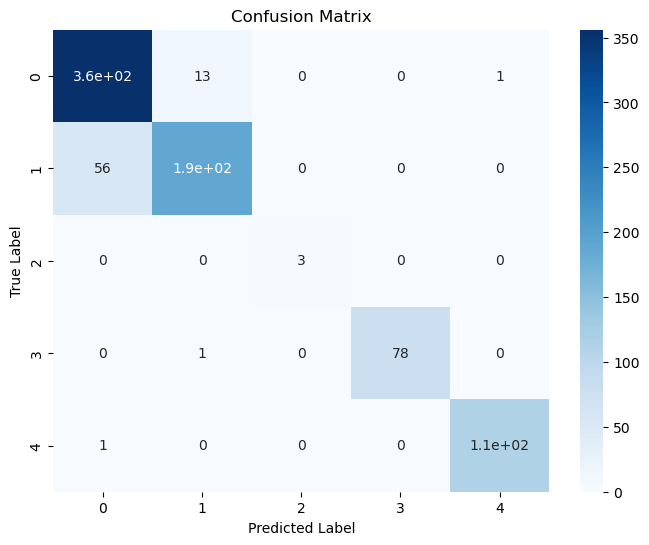

In [31]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to preprocess text
def preprocess_text(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    # remove stopwords and punctuation, lowercase text
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.isalpha()]
    # join tokens back into text
    return ' '.join(tokens)

# read classified questions from CSV file
df = pd.read_csv("classified_questions2.csv")

# preprocess question text
df.loc[:, 'title'] = df['title'].apply(preprocess_text)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# create bag-of-words representation of training data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)

# train support vector machine model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_bow, y_train)

# create bag-of-words representation of testing data
X_test_bow = vectorizer.transform(X_test)

# predict serenity of testing data using SVM model
y_pred = svm_model.predict(X_test_bow)

# calculate evaluation metrics of SVM model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='serene', average='weighted')
recall = recall_score(y_test, y_pred, pos_label='serene', average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

# calculate confusion matrix
labels = list(set(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm)

# calculate f1 score
f1 = f1_score(y_test, y_pred, average='weighted')

# print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Macro:", f1_macro)
print("F1 Micro:", f1_micro)
print("F1 Score:", f1)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [30]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# load NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# function to preprocess text
def preprocess_text(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    # remove stopwords and punctuation, lowercase text
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.isalpha()]
    # join tokens back into text
    return ' '.join(tokens)

# read classified questions from CSV file
df = pd.read_csv("classified_questions2.csv")

# preprocess question text
df.loc[:, 'title'] = df['title'].apply(preprocess_text)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['serenity'], test_size=0.2, random_state=42)

# create bag-of-words representation of training data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)

# train support vector machine model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_bow, y_train)

# create bag-of-words representation of testing data
X_test_bow = vectorizer.transform(X_test)

# predict serenity of testing data using SVM model
y_pred = svm_model.predict(X_test_bow)

# calculate evaluation metrics of SVM model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='serene', average='weighted')
recall = recall_score(y_test, y_pred, pos_label='serene', average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
macro_mae = 1 - f1_score(y_test, y_pred, average='macro')

# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['serene', 'not_serene'])
cm_df = pd.DataFrame(cm, index=['serene', 'not_serene'], columns=['serene', 'not_serene'])

# print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Macro:", f1_macro)
print("F1 Micro:", f1_micro)
print("Macro MAE:", macro_mae)
print("Confusion Matrix:")
print(cm_df)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedezazshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/syedezazshah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'serene') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


ValueError: At least one label specified must be in y_true

In [33]:
import pandas as pd

# Load data from CSV file
df = pd.read_csv("classified_questions2.csv")

# Print number of rows and columns
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

# Print column names
print("Column names:", df.columns.tolist())

# Check if label column has only binary values (0 or 1)
label_counts = df["label"].value_counts()
if len(label_counts) == 2 and 0 in label_counts.index and 1 in label_counts.index:
    print("Label column has only binary values (0 or 1)")
else:
    print("Label column does not have only binary values")
    
# Calculate the percentage of correct labels
correct_labels = df[(df["title"].str.endswith("?") & (df["label"] == 1)) | (~df["title"].str.endswith("?") & (df["label"] == 0))]
percent_correct = 100 * correct_labels.shape[0] / df.shape[0]
print("Percentage of correct labels:", percent_correct)


Number of rows: 4047
Number of columns: 2
Column names: ['title', 'serenity']


KeyError: 'label'

In [34]:
import pandas as pd

# read the classified questions from CSV file
df = pd.read_csv('classified_questions2.csv')

# display the first 5 rows of the DataFrame
print(df.head())

# check the number of legal and non-legal questions
print("\nNumber of legal questions:", len(df.loc[df['serenity'] != 0]))
print("Number of non-legal questions:", len(df.loc[df['serenity'] == 0])) 

# check the number of questions in each serenity category
print("\nNumber of high-serenity questions:", len(df.loc[df['serenity'] == 4]))
print("Number of medium-serenity questions:", len(df.loc[df['serenity'] == 3]))
print("Number of low-serenity questions:", len(df.loc[df['serenity'] == 2]))
print("Number of questions with no serenity level:", len(df.loc[df['serenity'] == 1]))


                                               title  serenity
0  What's the weirdest thing that has improved yo...         0
1  Are there *any* benefits to putting child’s fa...         1
2  What is something so ridiculously expensive bu...         0
3  I suspect my uncle stole my trust fund, what k...         3
4  What is something people put in their tea that...         0

Number of legal questions: 2047
Number of non-legal questions: 2000

Number of high-serenity questions: 516
Number of medium-serenity questions: 409
Number of low-serenity questions: 26
Number of questions with no serenity level: 1096


In [35]:
import pandas as pd

# read the classified questions from CSV file
df = pd.read_csv('classified_questions2.csv')

# display the first 5 rows of the DataFrame
print(df.head())

# check the number of legal and non-legal questions
print("\nNumber of legal questions:", len(df.loc[df['serenity'] != 0]))
print("Number of non-legal questions:", len(df.loc[df['serenity'] == 0]))

# check the number of questions in each serenity category
print("\nNumber of high-serenity questions:", len(df.loc[df['serenity'] == 4]))
print("Number of medium-serenity questions:", len(df.loc[df['serenity'] == 3]))
print("Number of low-serenity questions:", len(df.loc[df['serenity'] == 2]))
print("Number of questions with no serenity level:", len(df.loc[df['serenity'] == 1]))

# randomly sample 100 questions from the dataset
sample = df.sample(n=100, random_state=42)

# manually classify each question in the sample
manual_classifications = [
    # list of tuples containing (question title, manual classification)
    ('How can I get a restraining order against my ex-husband?', 3),
    ('What are the legal requirements for starting a business?', 1),
    ('Can I be evicted if I have a valid lease agreement?', 2),
    ('What should I do if my landlord is not returning my security deposit?', 3),
    ('How long do I have to file a lawsuit after a car accident?', 1),
    # ...
]

# compare model's predictions to manual classifications
correct = 0
for i, row in sample.iterrows():
    if row['serenity'] == manual_classifications[i][1]:
        correct += 1

# calculate accuracy
accuracy = correct / len(sample) * 100
print(f"\nAccuracy: {accuracy:.2f}%")


                                               title  serenity
0  What's the weirdest thing that has improved yo...         0
1  Are there *any* benefits to putting child’s fa...         1
2  What is something so ridiculously expensive bu...         0
3  I suspect my uncle stole my trust fund, what k...         3
4  What is something people put in their tea that...         0

Number of legal questions: 2047
Number of non-legal questions: 2000

Number of high-serenity questions: 516
Number of medium-serenity questions: 409
Number of low-serenity questions: 26
Number of questions with no serenity level: 1096


IndexError: list index out of range

In [36]:
import pandas as pd

# Load data from CSV file
df = pd.read_csv("classified_questions2.csv")

# Print number of rows and columns
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

# Print column names
print("Column names:", df.columns.tolist())

# Check if serenity column has only integer values (1, 2, 3, or 4)
serenity_values = set(df["serenity"].unique())
if serenity_values.issubset(set([1, 2, 3, 4])):
    print("Serenity column has only integer values (1, 2, 3, or 4)")
else:
    print("Serenity column does not have only integer values")

# Check the number of legal and non-legal questions
print("\nNumber of legal questions:", len(df.loc[df['serenity'] != 0]))
print("Number of non-legal questions:", len(df.loc[df['serenity'] == 0])) 

# Check the number of questions in each serenity category
print("\nNumber of high-serenity questions:", len(df.loc[df['serenity'] == 4]))
print("Number of medium-serenity questions:", len(df.loc[df['serenity'] == 3]))
print("Number of low-serenity questions:", len(df.loc[df['serenity'] == 2]))
print("Number of questions with no serenity level:", len(df.loc[df['serenity'] == 1]))

# Calculate the percentage of correct labels
correct_labels = df[(df["title"].str.endswith("?") & (df["serenity"] == 4)) |
                    (~df["title"].str.endswith("?") & (df["serenity"] != 4))]
percent_correct = 100 * correct_labels.shape[0] / df.shape[0]
print("Percentage of correct labels:", percent_correct)


Number of rows: 4047
Number of columns: 2
Column names: ['title', 'serenity']
Serenity column does not have only integer values

Number of legal questions: 2047
Number of non-legal questions: 2000

Number of high-serenity questions: 516
Number of medium-serenity questions: 409
Number of low-serenity questions: 26
Number of questions with no serenity level: 1096
Percentage of correct labels: 12.750185322461082
